In [1]:
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from math import radians, cos, sin, asin, sqrt

## Compute great-circle distance using haversine formula

In [2]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

## Create $n\times n$ matrix representing great-circle distance between any two input coordinates

In [3]:
def make_haversine_matrix(coords):
    # coordinates_list is a list of (lon,lat) tuples.
    X = np.zeros((len(coords), len(coords)))
    for i, (lon1,lat1) in enumerate(coords):
        for j, (lon2,lat2) in enumerate(coords):
            X[i,j] = haversine(lon1,lat1,lon2,lat2)
    return X

## Prim's algorithm to compute the minimum spanning tree

In [4]:
def minimum_spanning_tree(X): 
    '''
    Prim's algorithm
    '''
    X = X.copy()
    n_vertices = X.shape[0]
    spanning_edges = []
    total_cost = 0
    # Initialize with node 0
    visited_vertices = [0]
    num_visited = 1
    #exclude self connections
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
    while num_visited != n_vertices:
        # Take the argmin of the flattened array of visited vertices
        min_edge = np.argmin(X[visited_vertices], axis=None)
        # Convert index to 2D encoding
        min_edge = divmod(min_edge, n_vertices)
        # Create new edge
        source, sink = visited_vertices[min_edge[0]], min_edge[1]
        # Add edge to the tree
        spanning_edges.append([source,sink])
        visited_vertices.append(sink)
        total_cost += X[source,sink] 
        # Remove all edges inside current tree
        X[visited_vertices, sink] = np.inf
        X[sink, visited_vertices] = np.inf
        num_visited+=1
    
    if len(spanning_edges) == 0:
        return np.array(spanning_edges), total_cost
    return np.vstack(spanning_edges), total_cost

## Function to plot the minimum spanning tree on the Miller cylindrical projection of the world map (excluding Antarctica)

In [5]:
def plot_mst(coords, mst_edges, plot_title=None, box_text=None):
    
    plt.figure(figsize=(20,20))
    
    # Miller projection
    m = Basemap(projection='mill', 
                llcrnrlat=-60, 
                urcrnrlat=90, 
                llcrnrlon=-180, 
                urcrnrlon=180, 
                resolution='c')
    
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='#04BAE3', lake_color='#FFFFFF')
    m.drawmapboundary(fill_color='#FFFFFF')
    
    if len(mst_edges) == 0:
        for c in coords:
            x,y = m(c[0], c[1])
            m.plot(x,y, marker='o', color='r', markersize=7, alpha=1)
            
    for source,sink in mst_edges:
        lon1, lat1 = coords[source][0], coords[source][1]
        x1,y1 = m(lon1,lat1)
        lon2, lat2 = coords[sink][0], coords[sink][1]
        x2,y2 = m(lon2,lat2)
        
        m.plot([x1,x2],[y1,y2],marker='o', color='r',markersize=7, alpha=1)
    
    if box_text != None:
        plt.annotate(box_text, xy=(0.02, 0.05), xycoords='axes fraction', 
                     fontsize=20, fontweight='bold', color='r', 
                     bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

    
    if plot_title:
        plt.title(plot_title, fontweight='bold')
        
    plt.show()

## Toponym definition

In [6]:
class Toponym:
    def __init__(self, name, annotator_notes):
        # Remove non-alpha-numeric characters
        self.name = re.sub(r'([^\s\w]|_)+', '', name)
        
        # Latitude and Longitude (may be non-existent)
        latlon = re.findall(r'<latlng>(.*?)</latlng>', annotator_notes)
        if len(latlon) != 0 and latlon[0] != 'NA':
            latlon = latlon[0].split(',')
            self.lat, self.lon = float(latlon[0]), float(latlon[1])
        else:
            self.lat, self.lon = 'NA', 'NA'

        # Population (tag may be non-existent)
        pop = re.findall(r'<pop>(.*?)</pop>', annotator_notes)
        if len(pop) != 0:
            self.pop = int(pop[0])
        else:
            self.pop = 0
        
        # GeoID (some are 'NA')
        geoID = re.findall(r'<geoID>(.*?)</geoID>', annotator_notes)
        if len(geoID) != 0:
            self.geoID = geoID[0]
        else:
            self.geoID = 'NA'

## In some papers, authors abbreviate U.S. states by state codes. We manually define a mapping to the full state names. 

In [7]:
statecode_to_state = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'}

## Extract a list of toponyms from a document and removing toponyms tagged as "proteins"
The Protein tag is used to mark continuous spans of text that will be 
excluded from the evaluation, such spans are names of authors, reference, 
footnotes etc. They have been excluded from the annotations since they 
would not contain toponyms related to the biological content of the articles. 
Using document PMC2816729 as an example, the PMC2816729.ann file 
starts with the lines:

T1    Protein 0 8    American

#1    AnnotatorNotes T1    BEGIN

T2    Protein 559 571    Contribution

#2    AnnotatorNotes T2    END

In [8]:
def get_protein_intervals(annotation_file):
    intervals_to_exclude = []
    with open(annotation_file,'r') as infile:
        for line in infile:
            line = line.rstrip()
            if 'Protein' in line:
                start = int(line.split('\t')[1].split(' ')[1])
                #print(line.rstrip())
                while 'END' not in line:
                    previous_line = line
                    line = next(infile).rstrip()
                    #print(line)
                end = int(previous_line.split('\t')[1].split(' ')[2])
                #print(start, end)
                intervals_to_exclude.append((start,end))
    return intervals_to_exclude

In [9]:
def get_toponym_list(filepath):
    intervals_to_exclude = get_protein_intervals(filepath)
    toponym_list = []
    with open(filepath, 'r') as infile:        
        for line in infile:
            if 'Location' in line:
                data = line.rstrip().split('\t')
                
                try:
                    next_line = next(infile).rstrip()
                    annotator_notes = next_line.split('\t')[2]
                    placename = data[2]
                except IndexError as e:
                    print('Annotator notes messed up.\nLine: "%s".\nSee file %s'%(next_line,filepath))
                    time.sleep(500)

                # Hacky way to remove all but lower bound and upper bound. 
                # For example: ['Location', '42514', '42520;42521', '42528']
                start,end = [int(x) for x in data[1].split(' ') if ';' not in x and x !='Location']            

                # If this Location tag is a protein, exclude it. 
                for lower,upper in intervals_to_exclude:
                    if start >= lower and end <= upper:
                        continue
                # Else, add it to the list of toponyms.
                toponym_list.append(Toponym(placename, annotator_notes))
                
    return toponym_list

## The Geonames allCountries.txt header
Source of file: http://download.geonames.org/export/dump/

Source of header: http://download.geonames.org/export/dump/readme.txt

In [10]:
geonames_header = ['geonameid','name','asciiname','alternatenames','latitude','longitude','feature_class','feature_code','country_code','cc2','admin1_code','admin2_code','admin3_code','admin4_code','population', 'elevation', 'dem', 'timezone', 'modification_date']
print('Geonames header:')
for i,g in enumerate(geonames_header):
    print('%s) %s'%(i,g))

Geonames header:
0) geonameid
1) name
2) asciiname
3) alternatenames
4) latitude
5) longitude
6) feature_class
7) feature_code
8) country_code
9) cc2
10) admin1_code
11) admin2_code
12) admin3_code
13) admin4_code
14) population
15) elevation
16) dem
17) timezone
18) modification_date


## Create our database of place names and locations (using geonames)
To reduce the number of entries for a given place name, we define a window for which only a single entry will be appended to its list of possible locations. That is, if both longitude and latitude and within $d$ of another entry for a given place name, we do not include it in our database.

In [11]:
start_time = time.time()

coordinate_dict = {}

# User-defined window
thres = 10
# Geonames database
filename = '/home/julyankb/Workspace/COMP550/final_proj/geonames/allCountries.txt'
with open(filename, 'r') as infile:
    for i,line in enumerate(infile):
        data = line.split('\t')
        geoID = data[0]
        asciiname = re.sub(r'([^\s\w]|_)+', '', data[2]).lower()
        lat = np.float16(data[4])
        lon = np.float16(data[5])
        pop = int(data[14])
        
        #if pop == 0:
        #    continue
            
        if asciiname not in coordinate_dict:
            coordinate_dict[asciiname] = [(lon, lat, pop)]
        else:
            is_duplicate = 0
            for loc in coordinate_dict[asciiname]:
                '''
                There is repetitive information in the database. Two ways to solve:
                1) Store lon,lat as float16
                2) Only enter new element if distance smaller than d.
                '''
                if abs(lon - loc[0]) < thres and abs(lat - loc[1]) < thres:
                    is_duplicate = 1
                    break
                
            if not is_duplicate:
                coordinate_dict[asciiname].append((lon, lat, pop))

print('Time to load dict to memory:', time.time() - start_time)

Time to load dict to memory: 91.57019186019897


Distance Heuristic:


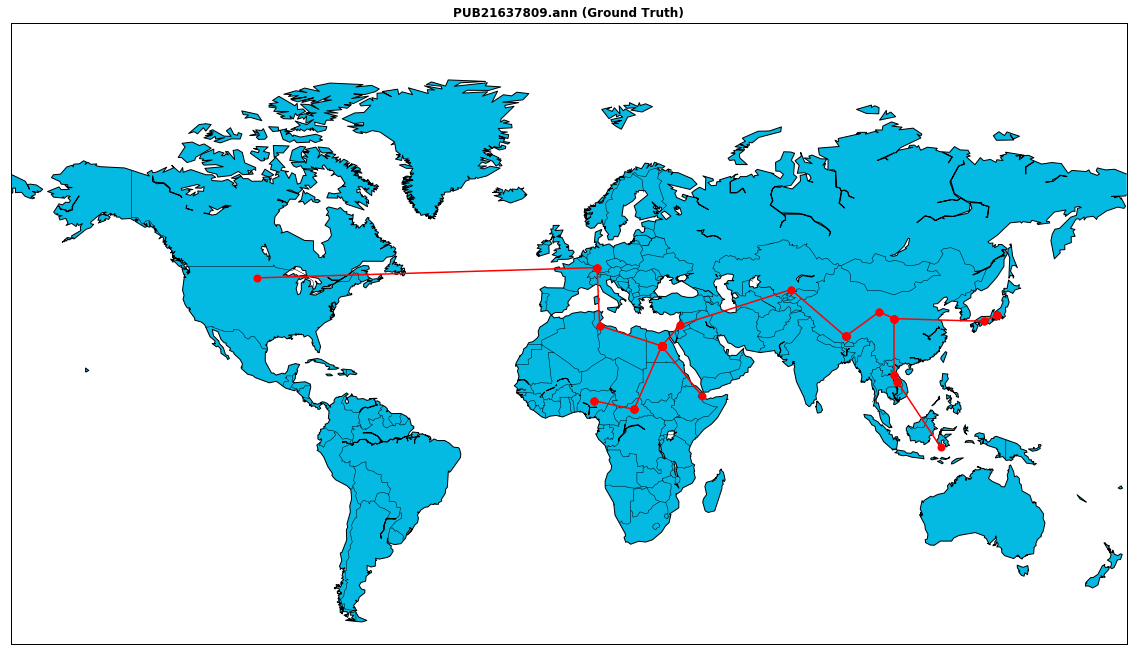

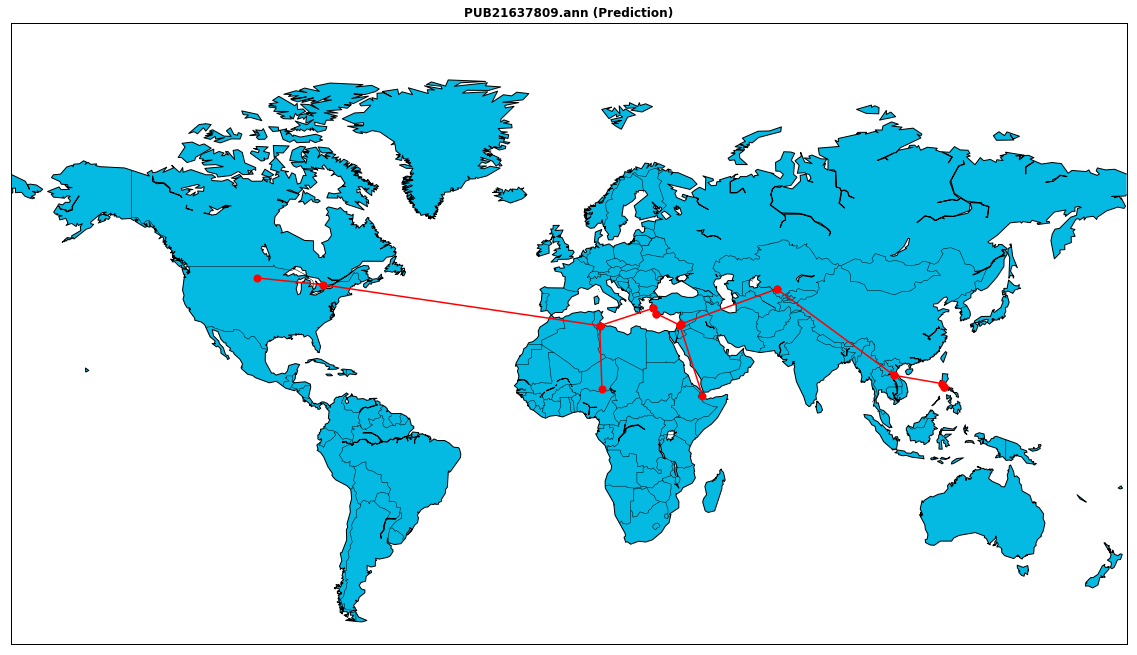

Largest Population Heuristic:


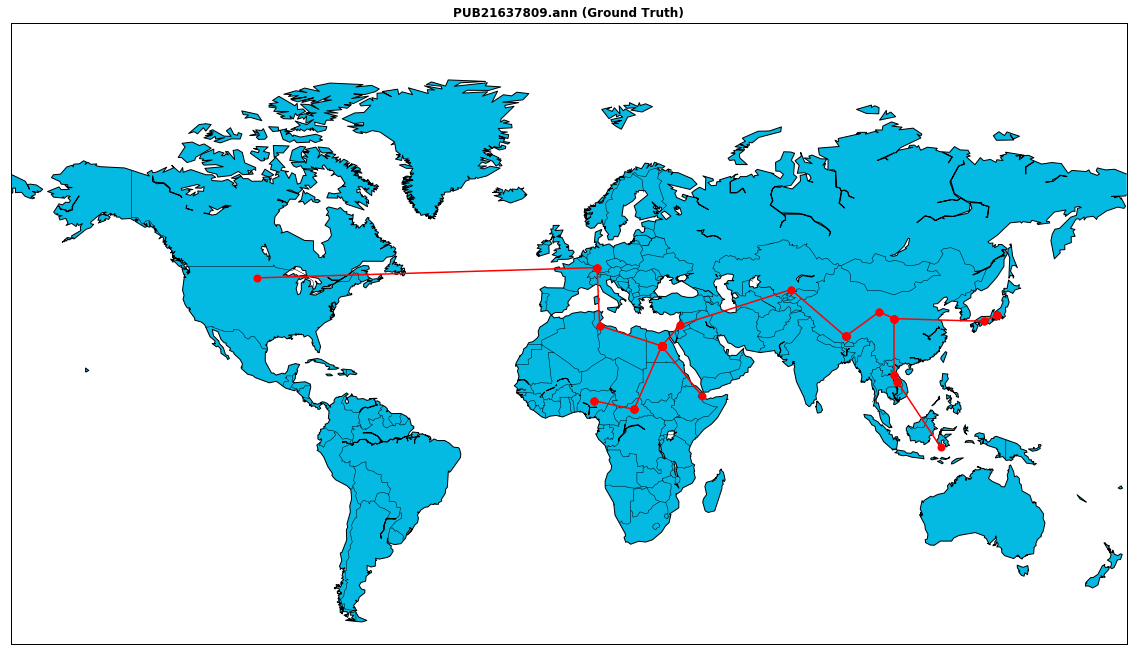

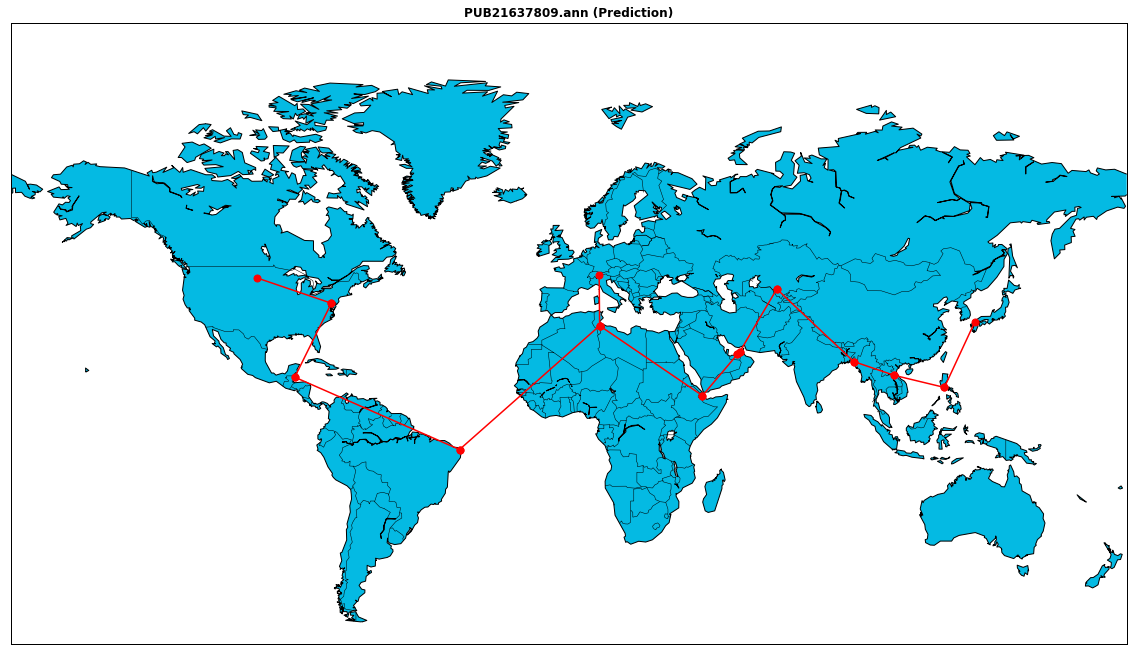

In [12]:
filedir = 'Training-20181121T061157Z-001/Training/Training_Data_Participant/'

accuracies_distance = []
accuracies_baseline = []

files = [f for f in os.listdir(filedir) if '.ann' in f]

distance_thresholds = np.linspace(0,15000,100)

for d in distance_thresholds:
    total_acc_distance = 0
    total_acc_baseline = 0
    
    for count, filename in enumerate(files):

        coords = []
        placenames = []
        ground_truth = {}

        toponym_list = get_toponym_list(filedir+filename)
        if len(toponym_list) == 0:
            continue

        for t in toponym_list:
            # If the longitude and latitude are existent, consider the toponym. 
            if t.lon != 'NA' and t.lat != 'NA':
                # Make sure coordinates are possible, ie. abs(lat) < 90 abs(lon) < 180
                if (-180 <= t.lon <= 180) and (-90 <= t.lat <= 90):
                    coords.append((t.lon, t.lat))
                    if t.name in statecode_to_state:
                        placenames.append(statecode_to_state[t.name].lower())
                        ground_truth[statecode_to_state[t.name].lower()] = (t.lon, t.lat)
                    else:
                        placenames.append(t.name.lower())
                        ground_truth[t.name.lower()] = (t.lon, t.lat)

        toponym_coordlists = []
        placenames = list(set(placenames))

        placenames_toremove = []

        for i, place in enumerate(placenames):
            if place in coordinate_dict:
                toponym_coordlists.append(coordinate_dict[place])
            else:
                # The toponym is not in our database.
                placenames_toremove.append(i)
                continue

        placenames = [p for i,p in enumerate(placenames) if i not in placenames_toremove]

        if len(placenames) == 0:
            continue
        # ==================================================================================

        # By distance heuristic
        new_placenames = []
        new_coords = []
        for place,t in zip(placenames,toponym_coordlists):
            if len(t) == 1:
                new_coords.append(t[0])
                new_placenames.append(place)
        for place, coordlist in zip(placenames,toponym_coordlists):
            if len(coordlist) > 1:
                min_cost, min_coord = np.inf, None
                for coord in coordlist:
                    temp = [(c[0],c[1]) for c in new_coords + [coord]]
                    haversine_matrix = make_haversine_matrix(temp)
                    mst_edges, total_cost = minimum_spanning_tree(haversine_matrix)
                    if total_cost < min_cost:
                        min_cost = total_cost
                        min_coord = coord
                new_coords.append(min_coord)
                new_placenames.append(place)
        total_predictions = 0
        correct_predictions = 0
        for name,c in zip(new_placenames, new_coords):
            c = (c[0], c[1])
            #if np.linalg.norm(abs(np.array(c) - np.array(ground_truth[name]))) < d:
            if haversine(c[0], c[1], ground_truth[name][0], ground_truth[name][1]) < d:
                correct_predictions +=1
            total_predictions +=1
        accuracy = correct_predictions/total_predictions
        total_acc_distance += accuracy
        
        if filename in ['PUB21637809.ann'] and d == 0:
            print('Distance Heuristic:')
            for _, c in zip(['Ground Truth', 'Prediction'],[coords, new_coords]):
                c = [(i[0],i[1]) for i in c]
                haversine_matrix = make_haversine_matrix(c)
                mst_edges, total_cost = minimum_spanning_tree(haversine_matrix)
                plot_mst(c, mst_edges, plot_title='%s (%s)'%(filename,_))
        

        # ==================================================================================

        # By largest population 
        new_placenames = []
        new_coords = []
        for place,t in zip(placenames,toponym_coordlists):
            if len(t) == 1:
                new_coords.append(t[0])
                new_placenames.append(place)
        for place, coordlist in zip(placenames, toponym_coordlists):
            if len(coordlist) > 1:
                max_pop, chosen_coord = np.inf, coordlist[0]
                for coord in coordlist:
                    population = coord[2]
                    if population > max_pop:
                        max_pop = population
                        chosen_coord = coord
                new_coords.append(chosen_coord)
                new_placenames.append(place)
        total_predictions = 0
        correct_predictions = 0
        for name,c in zip(new_placenames, new_coords):
            c = (c[0], c[1])
            #if np.linalg.norm(abs(np.array(c) - np.array(ground_truth[name]))) < d:
            if haversine(c[0], c[1], ground_truth[name][0], ground_truth[name][1]) < d:

                correct_predictions +=1
            total_predictions +=1
        accuracy = correct_predictions/total_predictions
        total_acc_baseline += accuracy
        
        if filename in ['PUB21637809.ann'] and d == 0:
            print('Largest Population Heuristic:')
            for _, c in zip(['Ground Truth', 'Prediction'],[coords, new_coords]):
                c = [(i[0],i[1]) for i in c]
                haversine_matrix = make_haversine_matrix(c)
                mst_edges, total_cost = minimum_spanning_tree(haversine_matrix)
                plot_mst(c, mst_edges, plot_title='%s (%s)'%(filename,_))

        # ==================================================================================

    accuracies_distance.append(total_acc_distance/count)
    accuracies_baseline.append(total_acc_baseline/count)

## Augmenting database manually

In [13]:
# All countries
with open('countries.csv', 'r') as infile:
    next(infile)
    for line in infile:
        data = line.rstrip().split('\t')
        name = data[3].lower()
        try:
            lat = float(data[1])
            lon = float(data[2])
        except:
            continue
        if name not in coordinate_dict:
            coordinate_dict[name] = [(lon,lat)]
        else:
            coordinate_dict[name].append((lon,lat, 0))
        
# Canadian Provinces
with open('canada.csv', 'r') as infile:
    next(infile)
    for line in infile:
        data = line.split(',')
        province = data[5].lower()
        lon,lat = float(data[2]), float(data[1])
        if province not in coordinate_dict:
            #print(province)
            coordinate_dict[province] = [(lon,lat)]
        else:
            is_duplicate = 0
            for loc in coordinate_dict[province]:
                if abs(lon - loc[0]) < thres and abs(lat - loc[1]) < thres:
                    is_duplicate = 1
                    break
                
            if not is_duplicate:
                coordinate_dict[province].append((lon, lat, 0))

# Venezuela states
with open('venezuela_states.csv', 'r') as infile:
    next(infile)
    for line in infile:
        data = line.split('\t')
        state = data[0].lower()
        
        lon,lat = float(data[2]), float(data[1])
        
        if state not in coordinate_dict:
            coordinate_dict[state] = [(lon,lat)]
        else:
            is_duplicate = 0
            for loc in coordinate_dict[state]:
                if abs(lon - loc[0]) < thres and abs(lat - loc[1]) < thres:
                    is_duplicate = 1
                    break
                
            if not is_duplicate:
                coordinate_dict[state].append((lon, lat, 0))

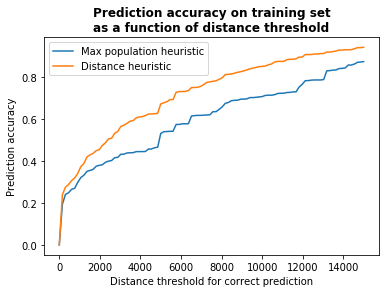

In [14]:
plt.plot(distance_thresholds, accuracies_baseline, label='Max population heuristic')
plt.plot(distance_thresholds, accuracies_distance, label='Distance heuristic')
plt.xlabel('Distance threshold for correct prediction')
plt.ylabel('Prediction accuracy')
plt.title('Prediction accuracy on training set\nas a function of distance threshold', fontweight='bold')
plt.legend()
plt.show()

# Repeating experiment with augmented database

Distance heuristic with manually augmented database


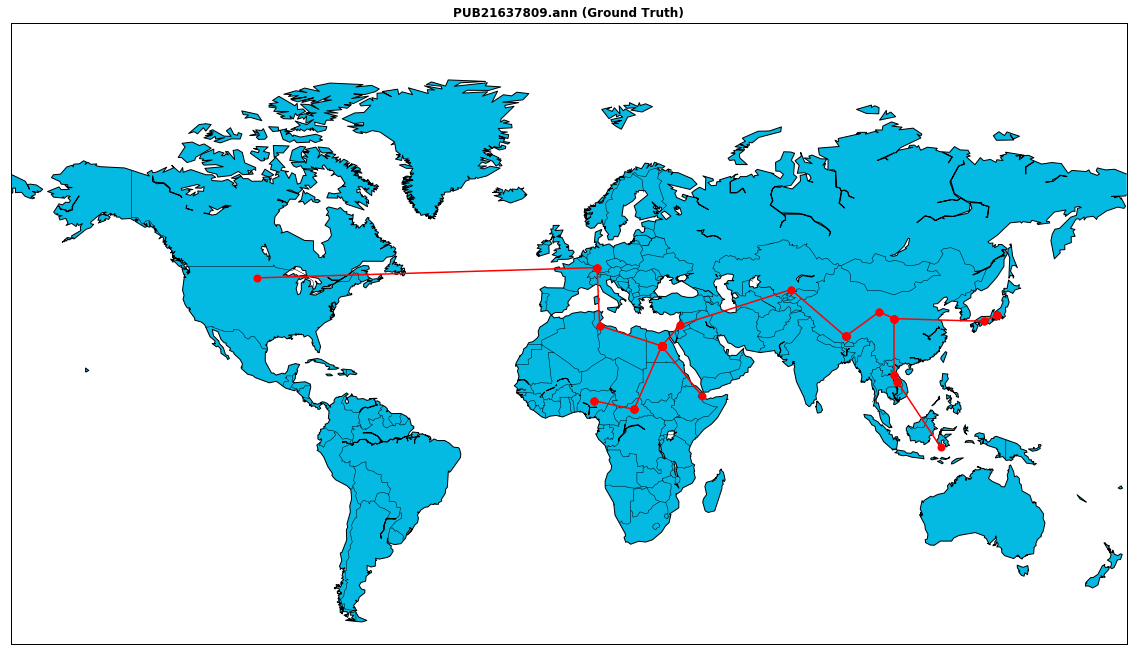

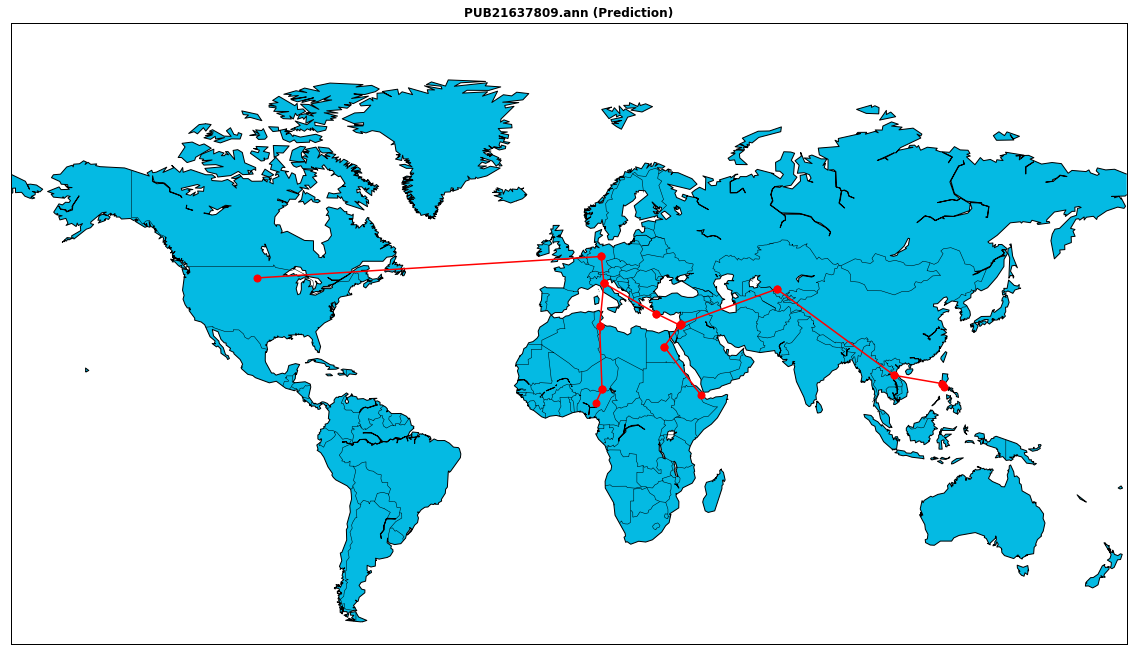

In [15]:
accuracies_distance_plus = []

for d in distance_thresholds:
    total_acc_distance_plus = 0
    
    for count, filename in enumerate(files):

        coords = []
        placenames = []
        ground_truth = {}

        toponym_list = get_toponym_list(filedir+filename)
        if len(toponym_list) == 0:
            continue

        for t in toponym_list:
            # If the longitude and latitude are existent, consider the toponym. 
            if t.lon != 'NA' and t.lat != 'NA':
                # Make sure coordinates are possible, ie. abs(lat) < 90 abs(lon) < 180
                if (-180 <= t.lon <= 180) and (-90 <= t.lat <= 90):
                    coords.append((t.lon, t.lat))
                    if t.name in statecode_to_state:
                        placenames.append(statecode_to_state[t.name].lower())
                        ground_truth[statecode_to_state[t.name].lower()] = (t.lon, t.lat)
                    else:
                        placenames.append(t.name.lower())
                        ground_truth[t.name.lower()] = (t.lon, t.lat)

        toponym_coordlists = []
        placenames = list(set(placenames))

        placenames_toremove = []

        for i, place in enumerate(placenames):
            if place in coordinate_dict:
                toponym_coordlists.append(coordinate_dict[place])
            else:
                # The toponym is not in our database.
                placenames_toremove.append(i)
                continue

        placenames = [p for i,p in enumerate(placenames) if i not in placenames_toremove]

        if len(placenames) == 0:
            continue
        # ==================================================================================
        # By distance heuristic, including manually included (lon,lat) pairs
        
        new_placenames = []
        new_coords = []
        
        for place,t in zip(placenames,toponym_coordlists):
            if len(t) == 1:
                new_coords.append(t[0])
                new_placenames.append(place)
        for place, coordlist in zip(placenames,toponym_coordlists):
            if len(coordlist) > 1:
                min_cost, min_coord = np.inf, None
                for coord in coordlist:
                    temp = [(c[0],c[1]) for c in new_coords + [coord]]
                    haversine_matrix = make_haversine_matrix(temp)
                    mst_edges, total_cost = minimum_spanning_tree(haversine_matrix)
                    if total_cost < min_cost:
                        min_cost = total_cost
                        min_coord = coord
                new_coords.append(min_coord)
                new_placenames.append(place)
        
        total_predictions = 0
        correct_predictions = 0
        for name,c in zip(new_placenames, new_coords):
            c = (c[0], c[1])
            #if np.linalg.norm(abs(np.array(c) - np.array(ground_truth[name]))) < d:
            if haversine(c[0], c[1], ground_truth[name][0], ground_truth[name][1]) < d:
                correct_predictions +=1
            total_predictions +=1
        accuracy = correct_predictions/total_predictions
        total_acc_distance_plus += accuracy
        
        
        if filename in ['PUB21637809.ann'] and d == 0:
            print('Distance heuristic with manually augmented database')
            for _, c in zip(['Ground Truth', 'Prediction'],[coords, new_coords]):
                c = [(i[0],i[1]) for i in c]
                haversine_matrix = make_haversine_matrix(c)
                mst_edges, total_cost = minimum_spanning_tree(haversine_matrix)
                plot_mst(c, mst_edges, plot_title='%s (%s)'%(filename,_))
        
        # ==================================================================================

    accuracies_distance_plus.append(total_acc_distance_plus/count)

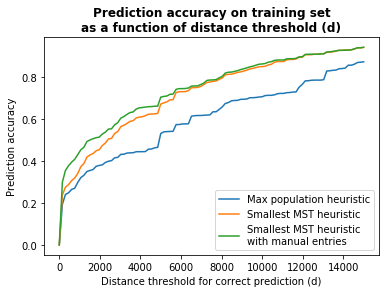

In [22]:
#plt.figure(figsize=(10,10))
plt.plot(distance_thresholds, accuracies_baseline, label='Max population heuristic')
plt.plot(distance_thresholds, accuracies_distance, label='Smallest MST heuristic')
plt.plot(distance_thresholds, accuracies_distance_plus, label='Smallest MST heuristic\nwith manual entries')
plt.xlabel('Distance threshold for correct prediction (d)')
plt.ylabel('Prediction accuracy')
plt.title('Prediction accuracy on training set\nas a function of distance threshold (d)', fontweight='bold')
plt.legend()
plt.show()